## 2nd Project | Trading

###  Instructions
- Follow a Python Project structure.
- Work with a training and validation dataset to optimize & test your trading strategies using the datasets provided in the introduction section.
- Select n technical indicators (one for each team member).
- For each timeframe train/test files (1d, 1h, 5m, 1m):
    - Define buy/sell signals for each indicator.
    - Create all possible combinations of all technical indicators (2^n - 1).
    - Backtest the strategies while keeping track of the operations and cash/portfolio value time series, remember that we'll be opening long & short positions.
    - Optimize all technical indicator's parameters (TPE, Grid Search, PSO, Genetic Algorithms, ...), stop-loss/take-profit, volume of the trade, maximizing the profit of the strategy with the training dataset, consider the bounds of each variable!
    - Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).
    - Now, use the optimal strategy with the test dataset and compare it to a passive strategy.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

data = pd.read_csv('aapl_1d_train.csv')

data = data.dropna()

rsi_data = ta.momentum.RSIIndicator(close = data.Close, window= 14)
data['RSI'] = rsi_data.rsi()

short_ma  = ta.trend.SMAIndicator(data.Close, window=5)
long_ma  = ta.trend.SMAIndicator(data.Close, window=21)
data["SHORT_SMA"] = short_ma.sma_indicator()
data["LONG_SMA"] = long_ma.sma_indicator()

macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()
data['Signal_Line'] = macd.macd_signal()

data['SAR'] = ta.trend.PSARIndicator(data['High'], data['Low'], data['Close'], step=0.02, max_step=0.2).psar()

adx_indicator = ta.trend.ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
data['ADX'] = adx_indicator.adx()
data['+DI'] = adx_indicator.adx_pos()
data['-DI'] = adx_indicator.adx_neg()
data['prev_DI+'] = data['+DI'].shift(1)
data['prev_DI-'] = data['-DI'].shift(1)

data = data.dropna()

In [3]:
data.head()

,Date,Open,High,Low,Close,Adjusted_close,Volume,RSI,SHORT_SMA,LONG_SMA,MACD,Signal_Line,SAR,ADX,+DI,-DI,prev_DI+,prev_DI-
33,2000-02-18,114.6208,115.3712,110.8800,111.2496,0.8420,233441600,51.598684,115.01280,109.744533,2.218192,1.890107,96.001393,8.096222,21.870373,23.467388,23.033916,22.062440
34,2000-02-22,110.1296,116.9392,106.6912,113.8144,0.8614,422296000,54.250846,114.61408,109.863467,2.187783,1.949642,96.480181,8.463104,19.455382,25.389513,21.870373,23.467388
35,2000-02-23,113.2320,119.0000,111.0032,116.2448,0.8798,473099200,56.673575,114.06304,110.339200,2.332905,2.026295,96.949394,8.394322,19.991612,23.233570,19.455382,25.389513
36,2000-02-24,117.3088,119.1232,111.7536,115.2032,0.8719,376432000,55.321430,114.27808,110.480000,2.336928,2.088421,97.409222,8.305508,18.567715,21.427761,19.991612,23.233570
37,2000-02-25,114.8112,116.9952,110.1296,110.3760,0.8354,249144000,49.434953,113.37760,110.489067,1.928372,2.056412,97.859853,8.515413,17.224567,21.588814,18.567715,21.427761


### RSI

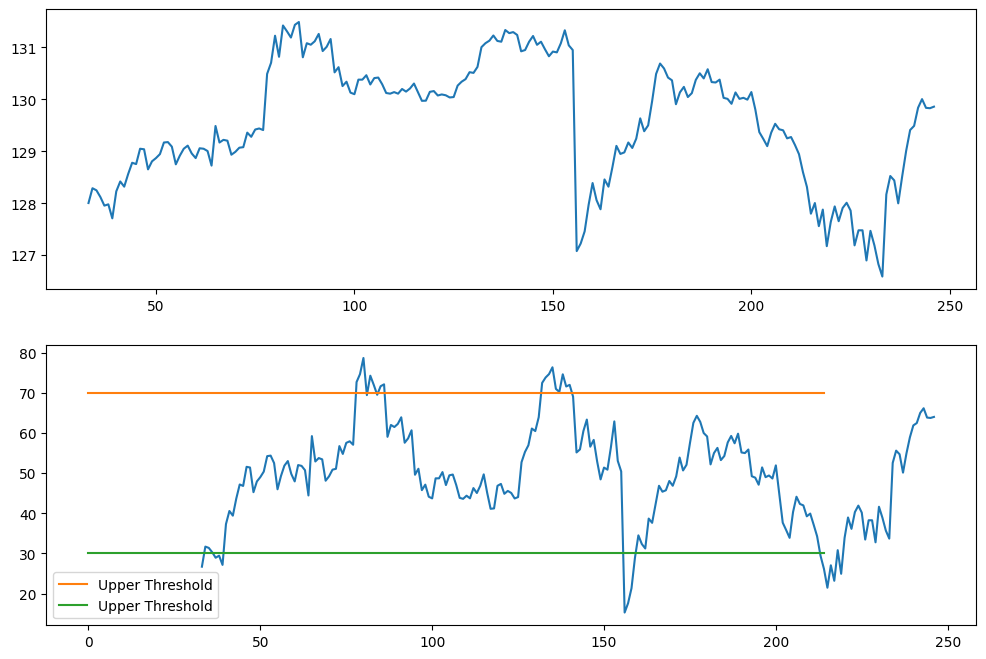

In [3]:
fig, axs = plt.subplots(2, 1, figsize = (12,8))


axs[0].plot(data.Close[:214])


axs[1].plot(data.RSI[:214])
axs[1].plot([0, 214], [70,70], label = "Upper Threshold")
axs[1].plot([0, 214], [30,30], label = "Upper Threshold")
plt.legend()

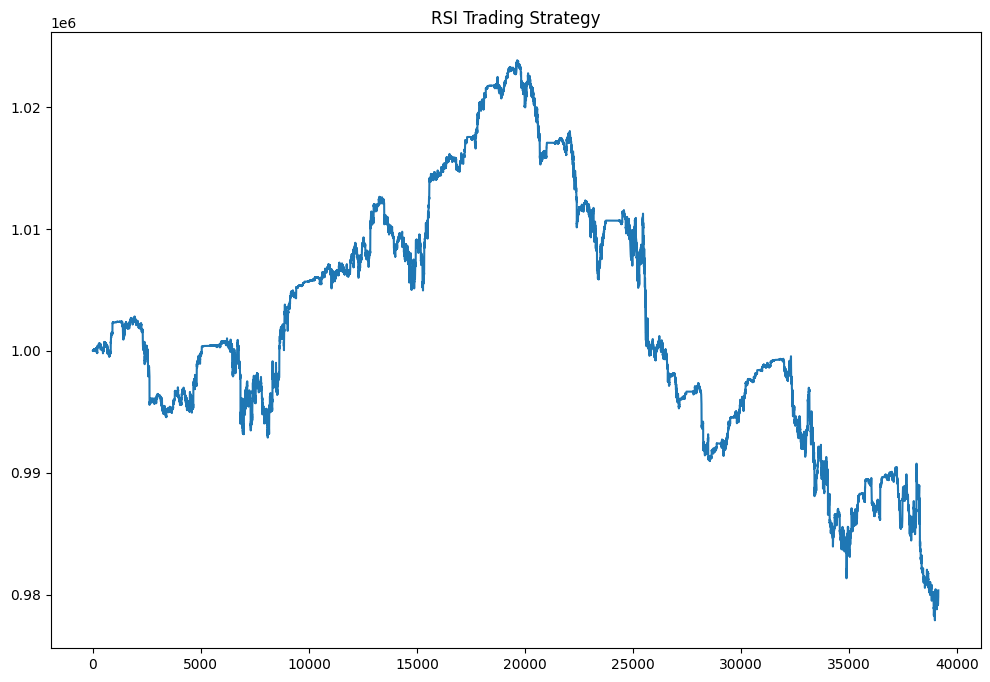

In [4]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for i, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close:
            cash += row.Close * op.n_shares * (1 - com)  
        elif op.take_profit < row.Close: # Close profit
            cash += row.Close * op.n_shares *  (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    if cash > row.Close * n_shares * (1 + com):   
        # Buy signal
        if row.RSI < 30:
            active_operations.append(Operation(operation_type = 'long', 
                                               bought_at = row.Close, 
                                               timestamp = row.Timestamp, 
                                               n_shares = n_shares,
                                               stop_loss = row.Close * 0.95,
                                               take_profit = row.Close * 1.05))
            cash -= row.Close * n_shares *  (1 + com)
            
    else:
        print('no money available..')
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)
        
        
plt.figure(figsize = (12, 8))
plt.plot(strategy_value)
plt.title('RSI Trading Strategy')
plt.show()

### SMA

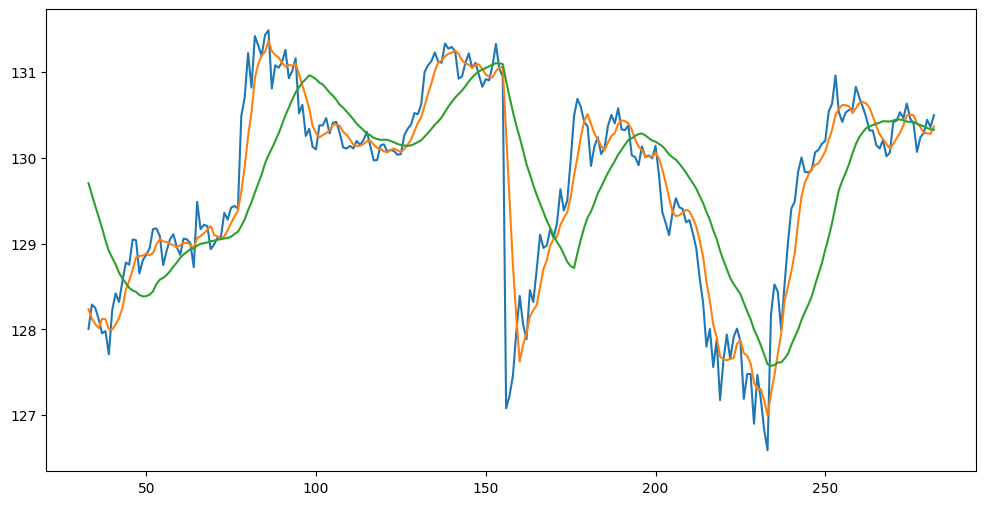

In [5]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close[:250], label = 'price')
plt.plot(data.SHORT_SMA[:250], label = 'SAM(5)')
plt.plot(data.LONG_SMA[:250], label = 'SMA(21)')

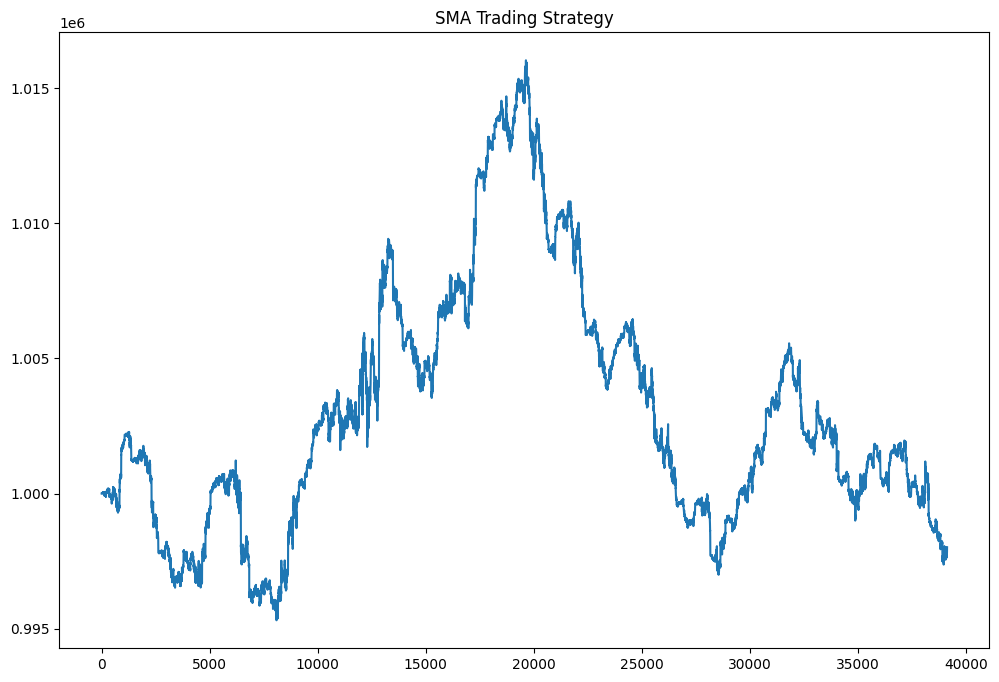

In [6]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

sma_sell_signal = data.iloc[0].LONG_SMA > data.iloc[0].SHORT_SMA 
sma_buy_signal = data.iloc[0].LONG_SMA < data.iloc[0].SHORT_SMA


for i, row in data.iterrows():
    # Close operations
    temp_operations = []
    for op in active_operations:
        # Close losing position
        if op.stop_loss > row.Close:
            cash += row.Close * op.n_shares * (1 - com)  
        elif op.take_profit < row.Close: # Close profit
            cash += row.Close * op.n_shares *  (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    if cash > row.Close * n_shares * (1 + com):   
        # Buy signal
        if (row.LONG_SMA < row.SHORT_SMA) and SMA_buy_signal == False:
            SMA_buy_signal =True
            #buy....
            active_operations.append(Operation(operation_type = 'long', 
                                               bought_at = row.Close, 
                                               timestamp = row.Timestamp, 
                                               n_shares = n_shares,
                                               stop_loss = row.Close * 0.95,
                                               take_profit = row.Close * 1.05))
            cash -= row.Close * n_shares *  (1 + com)
            
        elif row.LONG_SMA > row.SHORT_SMA:
            SMA_buy_signal =False
        
            
    else:
        print('no money available..')
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)
    
    
plt.figure(figsize = (12, 8))
plt.plot(strategy_value)
plt.title('SMA Trading Strategy')
plt.show()

### MACD

In [7]:
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data.tail()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,RSI,...,LONG_SMA,MACD,Signal_Line,SAR,ADX,+DI,-DI,prev_DI+,prev_DI-,Signal line
39573,19787,1672432500,0,2022-12-30 20:35:00,129.020004,129.050003,128.899993,129.039993,773964.0,65.879195,...,128.464853,0.137293,0.045704,128.391187,28.525374,26.848508,11.804718,28.146415,12.375380,0.045704
39574,19788,1672432800,0,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,833767.0,66.256388,...,128.497233,0.151129,0.066789,128.454292,29.547598,27.579529,11.037387,26.848508,11.804718,0.066789
39575,19789,1672433100,0,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,2136910.0,73.176111,...,128.556762,0.186174,0.090666,128.512348,31.268525,32.466832,9.796526,27.579529,11.037387,0.090666
39576,19790,1672433400,0,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,2879267.0,78.731380,...,128.636019,0.242174,0.120968,128.601112,33.811895,41.432915,8.224302,32.466832,9.796526,0.120968
39577,19791,1672433700,0,2022-12-30 20:55:00,129.764999,129.949996,129.619995,129.949996,3896812.0,80.798987,...,128.721738,0.298093,0.156393,128.760578,36.200736,38.362421,7.510367,41.432915,8.224302,0.156393


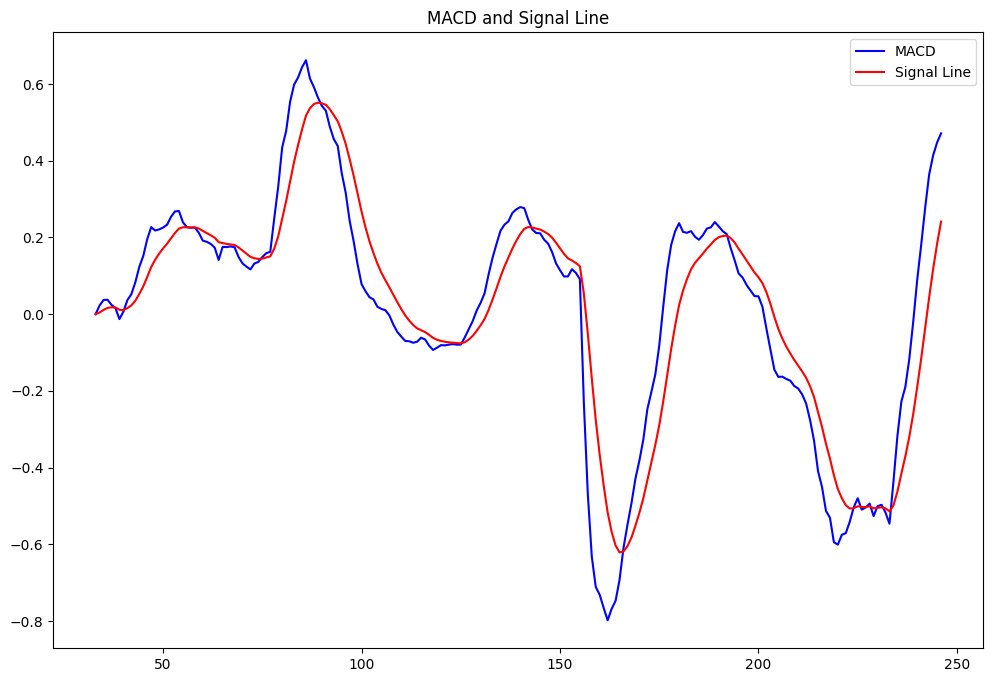

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))

# Graficar el MACD
plt.plot(data.index[:214], data['MACD'][:214], label='MACD', color='blue')

# Graficar la línea de señal
plt.plot(data.index[:214], data['Signal line'][:214], label='Signal Line', color='red')

# Añadir un título y una leyenda
plt.title('MACD and Signal Line')
plt.legend()

plt.show()


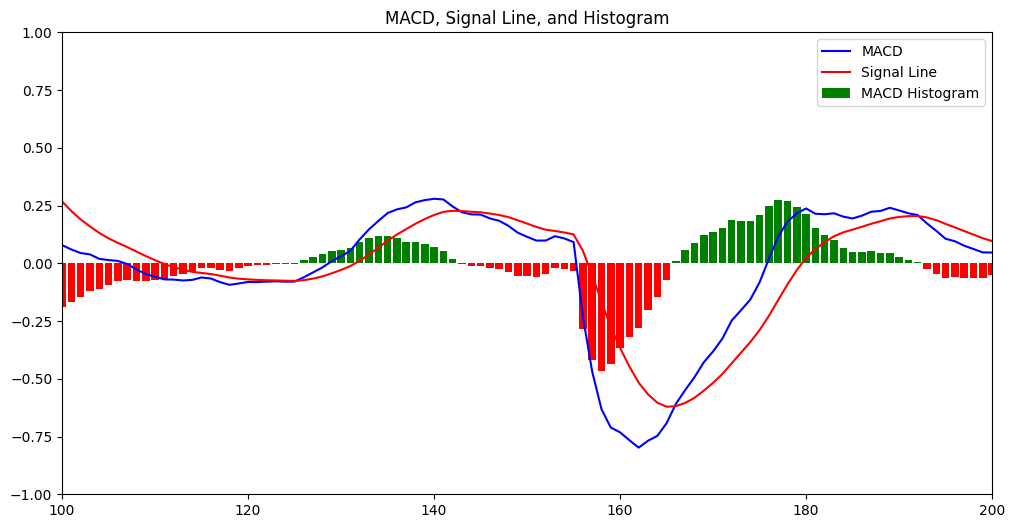

In [18]:
data['MACD_Histogram'] = data['MACD'] - data['Signal line']

plt.figure(figsize=(12, 6))

# Graficar el MACD y la línea de señal
plt.plot(data.index, data['MACD'], label='MACD', color='blue')
plt.plot(data.index, data['Signal line'], label='Signal Line', color='red')

# Rellenar el histograma entre el MACD y la línea de señal
# Usaremos un color diferente dependiendo si el histograma es positivo o negativo
plt.bar(data.index, data['MACD_Histogram'], label='MACD Histogram', color=['green' if val >= 0 else 'red' for val in data['MACD_Histogram']])

# Añadir un título y una leyenda
plt.title('MACD, Signal Line, and Histogram')
plt.legend()
plt.xlim(100,200)
plt.ylim(-1,1)
plt.show()


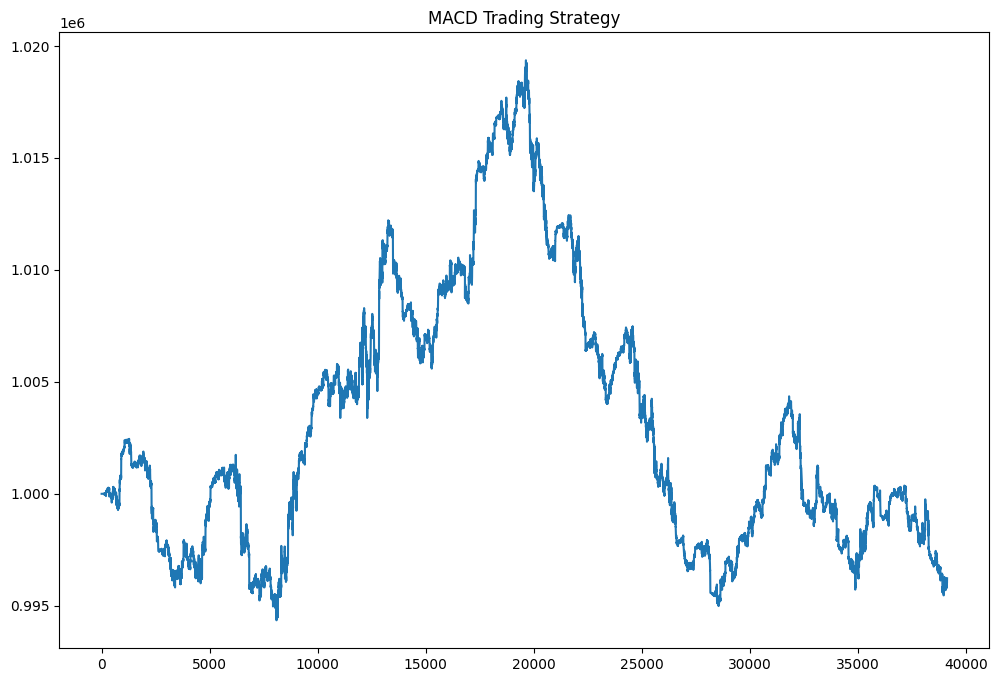

In [12]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for i, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close: 
            cash += row.Close * op.n_shares * (1 - com)
        elif op.take_profit < row.Close:  
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    # Verificamos si tenemos suficiente efectivo
    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra: la línea MACD cruza por encima de la línea de señal
        prev_macd = data['MACD'].shift(1)[i]  # Valor MACD de la fila anterior
        prev_signal = data['Signal_Line'].shift(1)[i]  # Valor de la línea de señal de la fila anterior
        if row['MACD'] > row['Signal_Line'] and prev_macd < prev_signal:
            active_operations.append(Operation(operation_type='long',
                                                bought_at=row.Close,
                                                timestamp=row.Timestamp,
                                                n_shares=n_shares,
                                                stop_loss=row.Close * 0.95,
                                                take_profit=row.Close * 1.05))
            cash -= row.Close * n_shares * (1 + com)
    else:
        print('no money available..')
    
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('MACD Trading Strategy')
plt.show()

### SAR

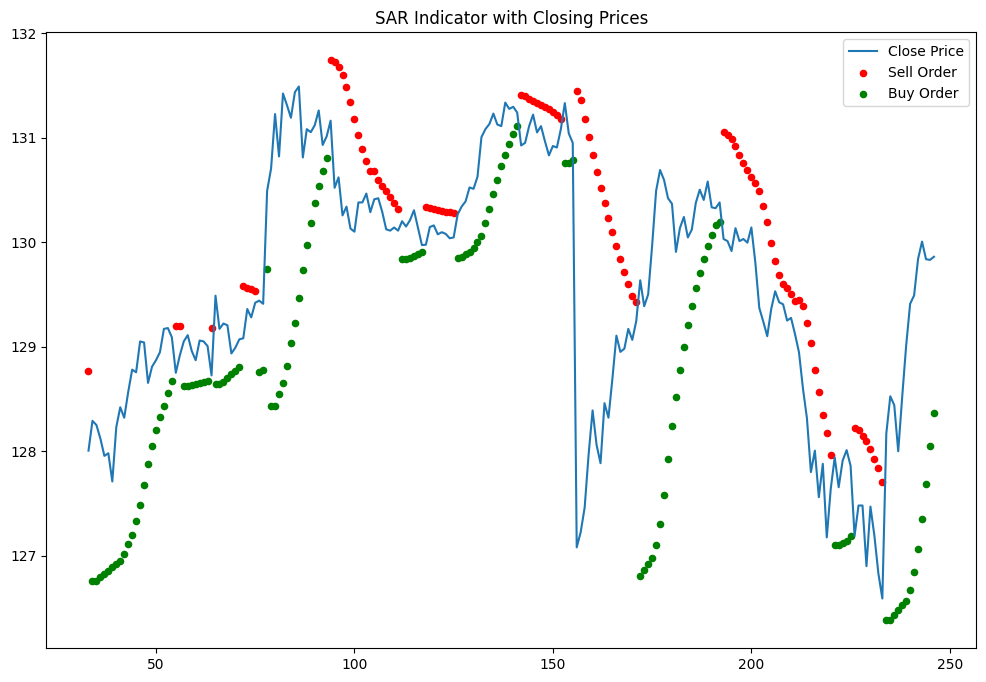

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(data.Close.iloc[:214], label='Close Price')

legend_added_buy = False
legend_added_sell = False

for i in range(214):
    if data.SAR.iloc[i] < data.Close.iloc[i]:
        color = 'green'
        label = 'Buy Order' if not legend_added_buy else None  
        legend_added_buy = True
    else:
        color = 'red'
        label = 'Sell Order' if not legend_added_sell else None  
        legend_added_sell = True
    
    plt.scatter(data.index[i], data.SAR.iloc[i], color=color, s=20, label=label)

if not legend_added_buy:
    plt.scatter([], [], color='green', s=20, label='Buy Order')
if not legend_added_sell:
    plt.scatter([], [], color='red', s=20, label='Sell Order')

plt.title('SAR Indicator with Closing Prices')
plt.legend()
plt.show()

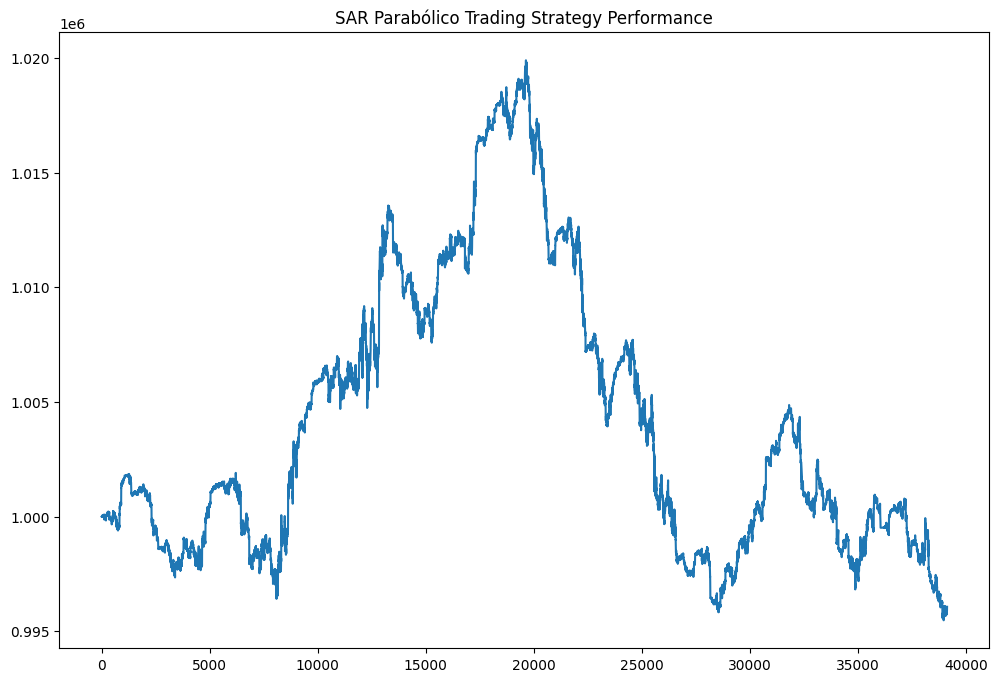

In [14]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10
data['prev_SAR'] = data['SAR'].shift(1)

for index, row in data.iterrows():

    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close or op.take_profit < row.Close:
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations

    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra: puntos del SAR pasan de estar arriba a debajo del precio
        if pd.notnull(row['prev_SAR']):  # Asegura que el valor previo de SAR no sea NaN
            if row['SAR'] < row['Close'] and row['prev_SAR'] > row['Close']:
                active_operations.append(Operation('long', row.Close, row.Timestamp, n_shares, row.Close * 0.95, row.Close * 1.05))
                cash -= row.Close * n_shares * (1 + com)

    
    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('SAR Parabólico Trading Strategy Performance')
plt.show()

### ADX

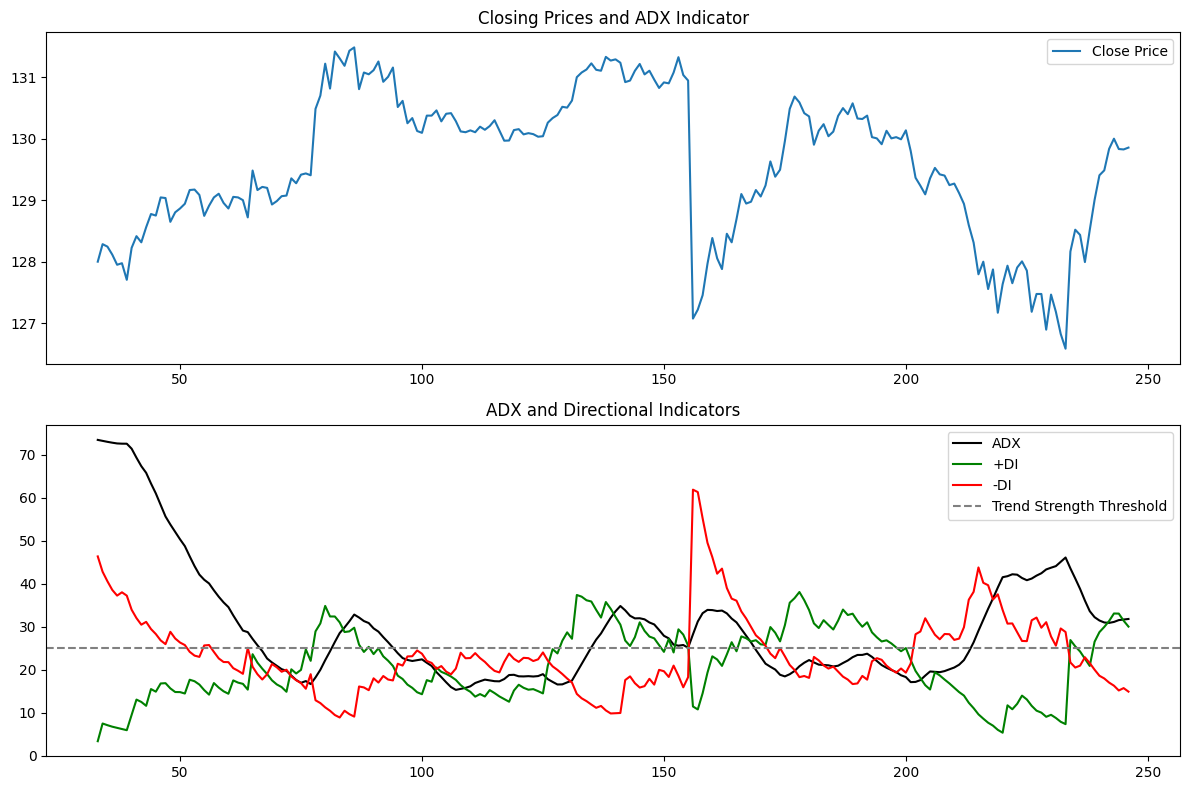

In [15]:
plt.figure(figsize=(12, 8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(data.Close.iloc[:214], label='Close Price')
ax1.set_title('Closing Prices and ADX Indicator')
ax1.legend()

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(data['ADX'].iloc[:214], label='ADX', color='black')
ax2.plot(data['+DI'].iloc[:214], label='+DI', color='green')
ax2.plot(data['-DI'].iloc[:214], label='-DI', color='red')

ax2.axhline(25, color='gray', linestyle='--', label = 'Trend Strength Threshold')

ax2.set_title('ADX and Directional Indicators')
ax2.legend()

plt.tight_layout()
plt.show()

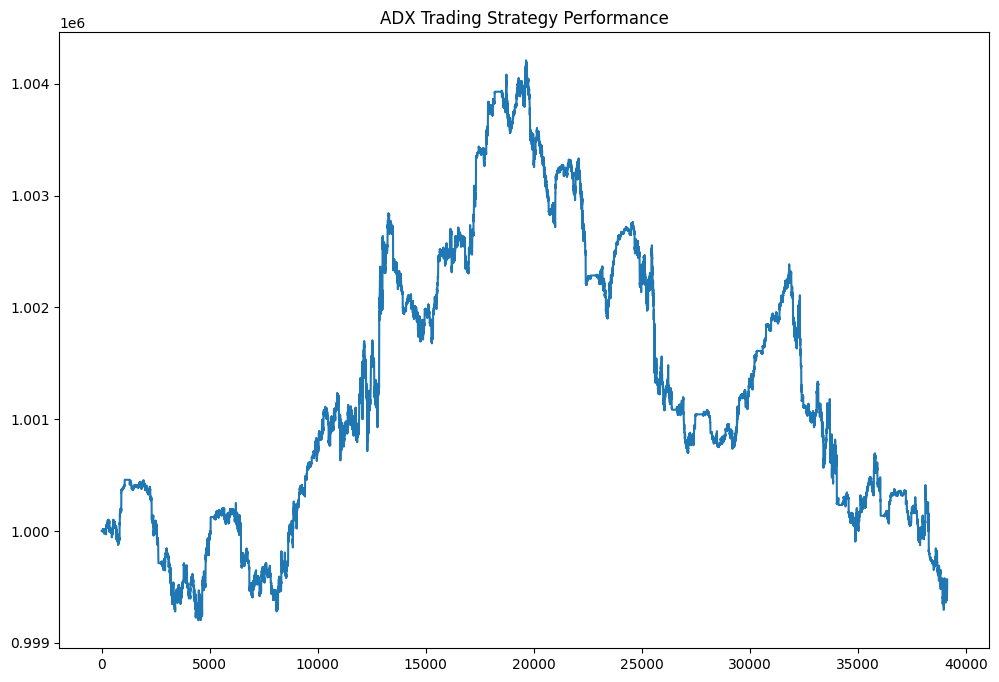

In [16]:
data = data.dropna()

cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for index, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close or op.take_profit < row.Close:
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations

    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra
        if pd.notnull(row['prev_DI+']) and pd.notnull(row['prev_DI-']):  # Verifica que los valores previos no sean NaN
            if row['+DI'] > row['-DI'] and row['ADX'] > 25 and row['prev_DI+'] < row['prev_DI-']:
                active_operations.append(Operation('long', row.Close, row.Timestamp, n_shares, row.Close * 0.95, row.Close * 1.05))
                cash -= row.Close * n_shares * (1 + com)


    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('ADX Trading Strategy Performance')
plt.show()

## Pasive Strategy
Passive investing is an investment strategy to maximize returns by minimizing buying and selling.

In [16]:
# Convertir la columna 'Date' a tipo datetime
data['Date'] = pd.to_datetime(data['Date'])

# Obtener el precio de cierre del primer y último dato
primer_cierre = data.iloc[0]['Close']
ultimo_cierre = data.iloc[-1]['Close']

# Calcular el rendimiento del activo
rend_pasivo = (ultimo_cierre - primer_cierre) / primer_cierre

print("El rendimiento del activo desde el primer cierre hasta el último cierre es: {:.2%}".format(rend_pasivo))


El rendimiento del activo desde el primer cierre hasta el último cierre es: 19.27%


In [17]:
# Comparativa con la estrategia utilizada
cash = 1000000
#strategy.strategy_value[-1] 
cashfinal = 1107153.05
rend_estrategia = (#strategy.strategy_value[-1]
    cashfinal- cash) / cash
print("El rendimiento de la estrategia desde el primer cierre hasta el último cierre es: {:.2%}".format(rend_estrategia))

El rendimiento de la estrategia desde el primer cierre hasta el último cierre es: 10.72%


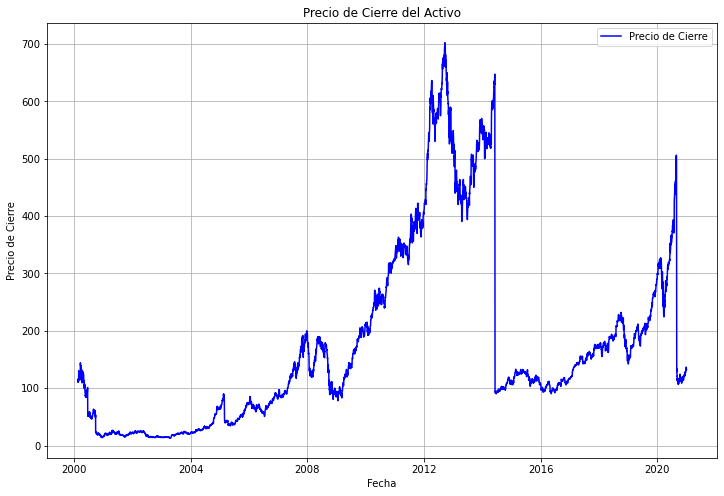

In [18]:
# Ordenar los datos por fecha si no están ordenados
data = data.sort_values(by='Date')
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre del Activo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.grid(True)
plt.show()


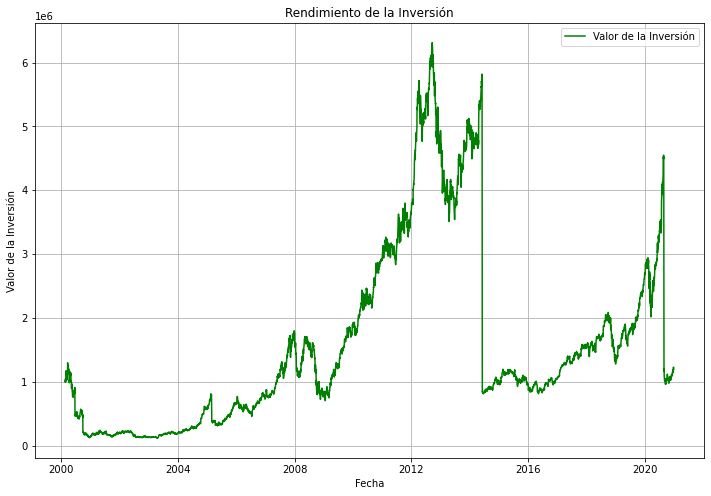

In [19]:
# Calcular el rendimiento acumulado
data['Returns'] = data['Close'].pct_change().fillna(0)

# Calcular el valor acumulado
initial_investment = cash
data['Investment_Value'] = (1 + data['Returns']).cumprod() * initial_investment
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Investment_Value'], label='Valor de la Inversión', color='green')
plt.title('Rendimiento de la Inversión')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Inversión')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
valor_final = data['Investment_Value'].iloc[-1]
print("El valor final de la inversión: ${:,.2f}".format(valor_final))


El valor final de la inversión: $1,192,723.39
